## Generating New Faces From Face Dataset

Training a GAN model to learn to generate fake human faces based on a dataset of real faces (CelebA Dataset). 

In order to run the notebook you have to download the CelebA dataset (total size of 1Gb) yourself. I used this version [https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg) hosted on Google Drive. The create the trainset I added the first 60k images to the `./data/CELEBA/train/person` folder. 

This notebook uses a deep convolutional GAN to learn. For the VAE version of this experiment see the `celeba_vae.ipynb` notebook. 

In [37]:
# # Import disthe required libraries
import torch
import torch.nn as nn 
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from celeba_models import Generator, Discriminator
from util import weight_init

sns.set_style('darkgrid')

In [26]:
# Hyperparameters for the training procedure
batch_size = 200
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

# Transformations applied to the initial images
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(64),
    torchvision.transforms.CenterCrop(64),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the images from the `data/CELEBA` folder
dataset = torchvision.datasets.ImageFolder('./data/CELEBA', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

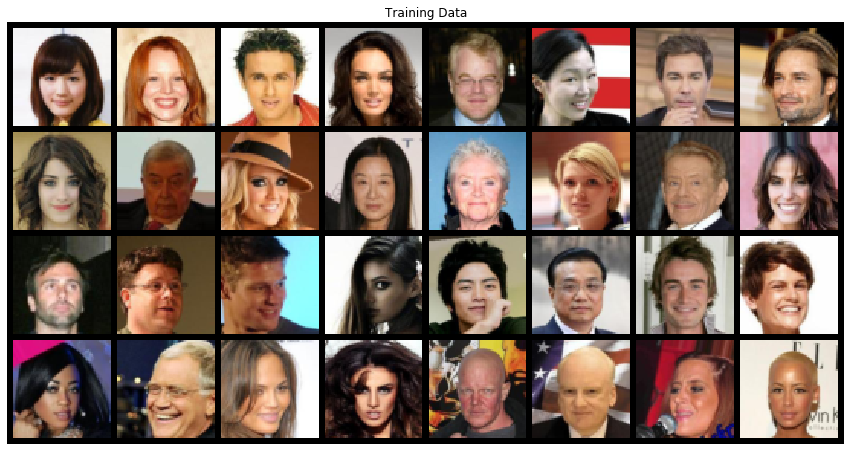

In [27]:
# Visualize some of the training data
plt.figure(figsize=(15, 8))
data, _ = next(iter(dataloader))

# Remove normalization from images and restore original images for correct visualization
data = data * 0.5 + 0.5

grid = torchvision.utils.make_grid(data[:32], nrow=8, padding=4)
plt.imshow(grid.permute(1, 2, 0))
plt.title('Training Data')
plt.axis('off')
plt.show()

### Training

Loading and training the generator and discriminator model. The full model structure is defined in the `celeba_model.py` file.

In [28]:
latent_size = 100 # size of z vector
generator = Generator().to(device)
generator.apply(weight_init)
discriminator = Discriminator().to(device)
discriminator.apply(weight_init)

criterion = nn.BCELoss()
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=7e-4, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))

print(generator)
print(discriminator)

Generator(
  (deconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
)
Discriminator(
  (dropout): Dropout2d(p=0.2, inplace=False)
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm1): B

In [29]:
# Save loss and accuracy for plot
list_discriminator_fake = []
list_discriminator_real = []
list_generator = []

# Helper function to generate and save images ever so often: 
def save_images(file_name):
    noise = torch.randn((32, latent_size)).to(device)
    x = generator(noise)
    
    # Remove normalization from images and restore original images for correct visualization
    x = x * 0.5 + 0.5

    plt.figure(figsize=(15, 8))
    grid = torchvision.utils.make_grid(x, nrow=8, padding=4)
    plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
    plt.axis('off')
    plt.savefig('./images/' + file_name)
    plt.close()


In [30]:
epochs = 4
label_smooth = 0.1
real_labels, fake_labels = 1.0 - label_smooth, 0.0

y_real = torch.full((batch_size, 1), real_labels).to(device)
y_fake = torch.full((batch_size, 1), fake_labels).to(device)

discriminator_steps = 2
generator_steps = 1

for e in range(epochs):
    for (idx, data) in enumerate(dataloader, 0):

        running_discriminator_loss = 0
    
        for _ in range(discriminator_steps):
            discriminator_optimizer.zero_grad()

            # Train discriminator on real training data
            x, _ = data
            x = x.to(device)

            y_pred = discriminator(x)
            error_real = criterion(y_pred, y_real)
            error_real.backward()

            # Train discriminator on fake training data
            noise = torch.randn((batch_size, latent_size)).to(device)
            x_fake = generator(noise)
            y_pred = discriminator(x_fake.detach())
            error_fake = criterion(y_pred, y_fake)
            error_fake.backward()

            discriminator_optimizer.step()

            running_discriminator_loss += error_real.item() + error_fake.item()
       
        # TODO: consider all iterations
        list_discriminator_fake.append(error_fake.item())
        list_discriminator_real.append(error_real.item())

        running_generator_loss = 0
        for _ in range(generator_steps):

            # Train generator to generate fake data
            generator_optimizer.zero_grad()
            noise = torch.randn((batch_size, latent_size)).to(device)
            x_fake = generator(noise)
            y_pred = discriminator(x_fake)
            generator_loss = criterion(y_pred, y_real)
            generator_loss.backward()

            generator_optimizer.step()

            running_generator_loss += generator_loss.item()      

        list_generator.append(running_generator_loss)

        if idx % 10 == 0:
            print("Epoch {}, Iteration {}/{} \t Loss Gen. {:.2f}, Loss Dic. {:.2f}".format(
                e, idx+1, len(dataset) // batch_size, 
                running_generator_loss, running_discriminator_loss
            ))

        if idx % 50 == 0:
            save_images(f"iteration_{e}_{idx}.png")

Epoch 0, Iteration 1/300 	 Loss Gen. 8.40, Loss Dic. 3.17
Epoch 0, Iteration 11/300 	 Loss Gen. 5.37, Loss Dic. 0.98
Epoch 0, Iteration 21/300 	 Loss Gen. 5.54, Loss Dic. 0.84
Epoch 0, Iteration 31/300 	 Loss Gen. 4.31, Loss Dic. 1.89
Epoch 0, Iteration 41/300 	 Loss Gen. 2.67, Loss Dic. 2.50
Epoch 0, Iteration 51/300 	 Loss Gen. 3.81, Loss Dic. 1.58
Epoch 0, Iteration 61/300 	 Loss Gen. 3.04, Loss Dic. 2.66
Epoch 0, Iteration 71/300 	 Loss Gen. 3.31, Loss Dic. 1.55
Epoch 0, Iteration 81/300 	 Loss Gen. 4.47, Loss Dic. 1.07
Epoch 0, Iteration 91/300 	 Loss Gen. 3.00, Loss Dic. 1.46
Epoch 0, Iteration 101/300 	 Loss Gen. 2.72, Loss Dic. 1.60
Epoch 0, Iteration 111/300 	 Loss Gen. 2.82, Loss Dic. 1.85
Epoch 0, Iteration 121/300 	 Loss Gen. 3.62, Loss Dic. 2.96
Epoch 0, Iteration 131/300 	 Loss Gen. 2.91, Loss Dic. 1.51
Epoch 0, Iteration 141/300 	 Loss Gen. 2.68, Loss Dic. 1.88
Epoch 0, Iteration 151/300 	 Loss Gen. 3.21, Loss Dic. 1.43
Epoch 0, Iteration 161/300 	 Loss Gen. 3.24, Loss D

### Visualizing the Training Loss

The loss over the duration of the training. Figure on the left-hand side shows the generator and discriminator loss. The figure on the right-hand side shows the discriminator loss split into the loss on the fake- and real training samples.

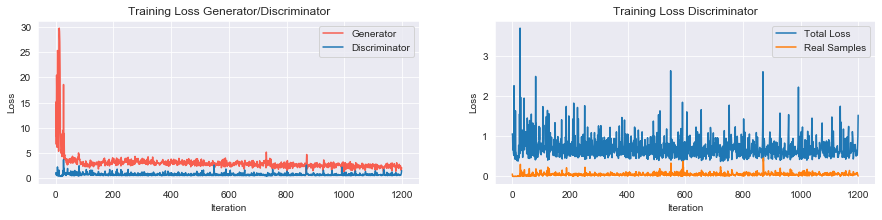

In [56]:
# Plot the training loss
plt.figure(figsize=(15, 3))

plt.subplot(121)
plt.title("Training Loss Generator/Discriminator")
plt.plot(list_generator, color='#f75e50')
plt.plot(np.array(list_discriminator_real) + np.array(list_discriminator_fake), color='#7d7769')
plt.xlabel("Iteration")
plt.legend(['Generator', 'Discriminator'])
plt.ylabel("Loss")

plt.subplot(122)
plt.title('Training Loss Discriminator')
plt.plot(list_discriminator_real)
plt.plot(list_discriminator_fake, color='#7d7769')
plt.xlabel("Iteration")
plt.legend(['Total Loss', 'Real Samples', 'Fake Samples'])
plt.ylabel("Loss")
plt.show()



### Testing

Testing the learned generator model to generate new faces learned from the dataset. 

We see that the model produces more "realistic" human faces than the VAE version (some actually look kinda scarry...).   
Maybe this can further be improved by longer training times or a modified model architecture in some upcoming version. 

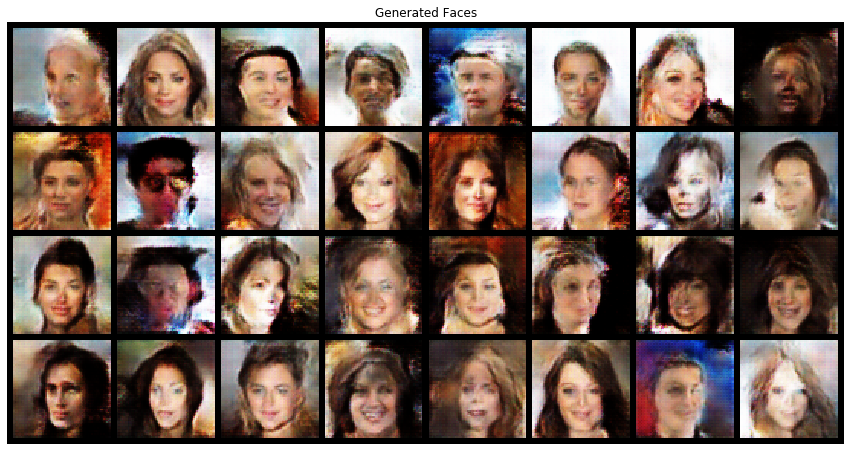

In [35]:
noise = torch.randn((32, latent_size)).to(device)
x = generator(noise) * 0.5 + 0.5

plt.figure(figsize=(15, 8))
grid = torchvision.utils.make_grid(x, nrow=8, padding=4)
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.title('Generated Faces')
plt.axis('off')
plt.show()